In [38]:
import seaborn as sns
import cv2
import os
import pandas as pd
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from PIL import Image
import torchvision
import pathlib
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision.datasets import ImageFolder
import warnings
import random
warnings.filterwarnings("ignore")




In [39]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])
])

train_path = ('/kaggle/input/brain-tumor/brain-tumor/Training/')
test_path = ('/kaggle/input/brain-tumor/brain-tumor/Testing/')

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=data_transforms),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=data_transforms),
    batch_size=32, shuffle=False
)

train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [41]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

root2=pathlib.Path(test_path)
classes2=sorted([j.name.split('/')[-1] for j in root2.iterdir()])

print(f'The classes are: {classes}')
print(f'The classes are: {classes2}')

The classes are: ['notumor', 'tumor']
The classes are: ['notumor', 'tumor']


In [43]:
for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
images.shape

torch.Size([27, 3, 224, 224])

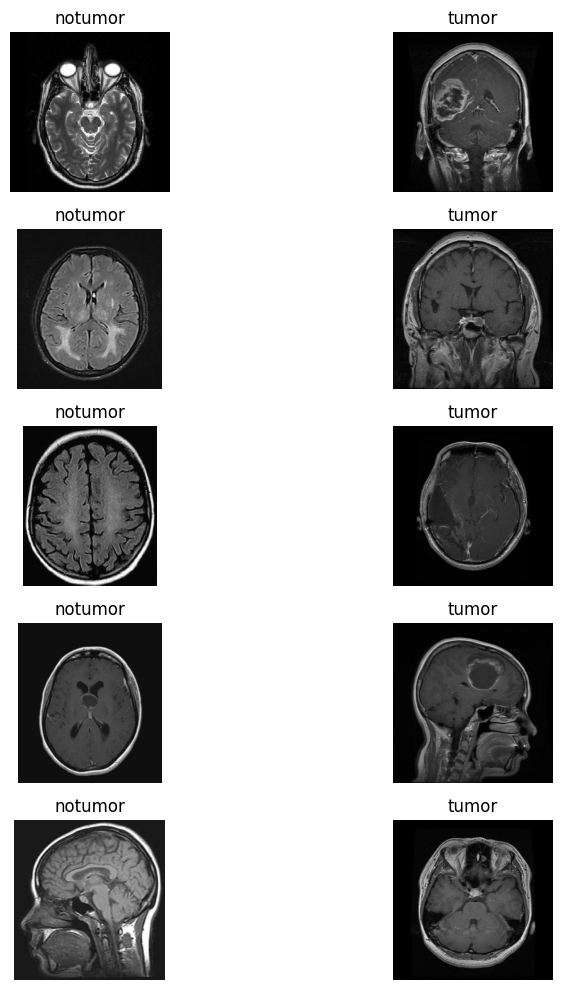

In [44]:
fig , axes = plt.subplots(5,2, figsize = (10,10))
categories = os.listdir('/kaggle/input/brain-tumor/brain-tumor/Training')
for i in range(len(categories)): 
    for j in range(5):
        category_path = os.path.join('/kaggle/input/brain-tumor/brain-tumor/Training', categories[i])
        category_images = random.sample(os.listdir(category_path) , 1)[0]
        random_image = os.path.join(category_path , category_images )
        axes[j , i].imshow(Image.open(random_image).convert("L") , cmap = 'gray')
        axes[j , i].set_title(categories[i])
        axes[j , i].set_axis_off()
        
plt.tight_layout()

In [46]:
train_img = []
train_labels = []

test_img = []
test_labels = []

for i in os.listdir(train_path):
    for j in os.listdir(train_path+i):
        train_img.append (cv2.resize(cv2.imread(train_path+i+'/'+j), (224,224))) 
        train_labels.append(i)
        
for i in os.listdir(test_path):
    for j in os.listdir(test_path+i):
        test_img.append (cv2.resize(cv2.imread(test_path+i+'/'+j), (224,224))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
test_img = (np.array(test_img))

train_labels_encoded = [0 if category == 'no_tumor' else 1 for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else 1 for category in list(test_labels)]

print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)



Shape of train:  (6107, 224, 224, 3)  and shape of test:  (1629, 224, 224, 3)


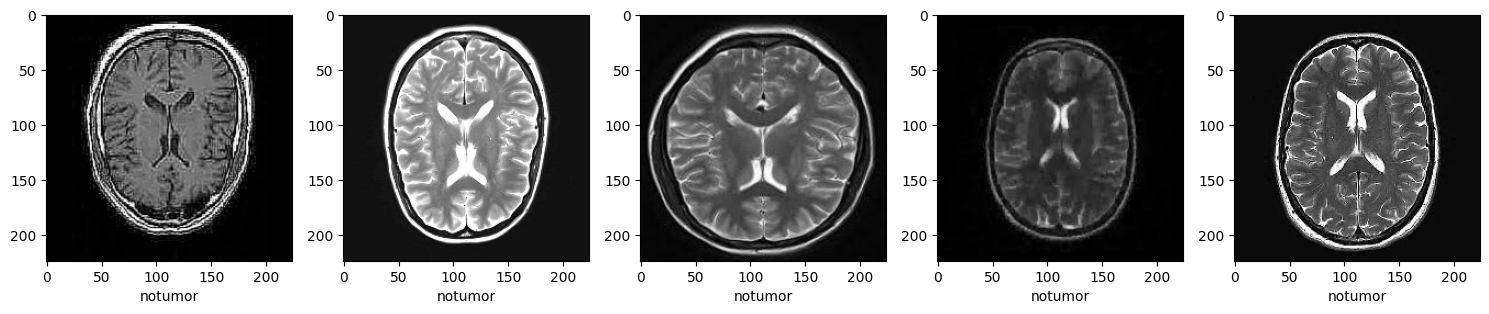

In [48]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break
        
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

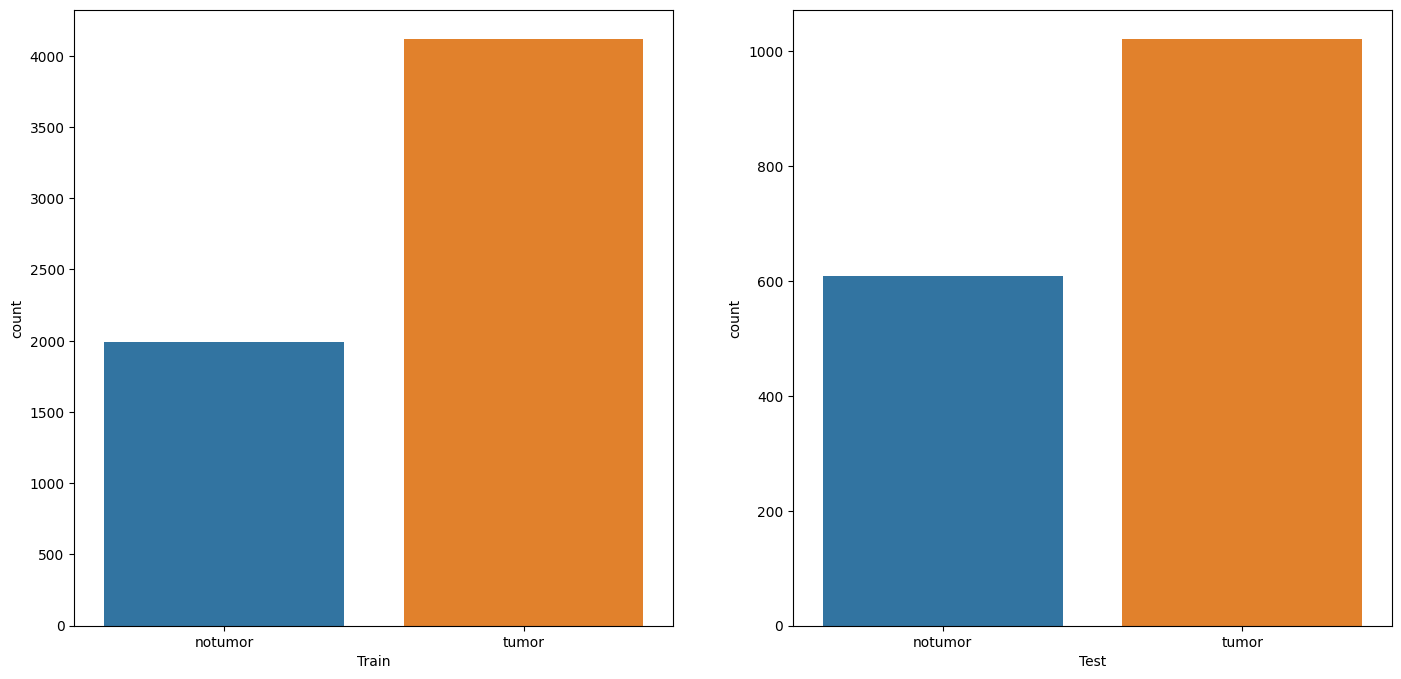

In [50]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [ ]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = TumorClassifier(num_classes=2)
model.to(device)

In [8]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()



best_accuracy=0.0

for epoch in range(12):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model,'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(0.3100) Train Accuracy: 0.9068282299001146 Test Accuracy: 0.8978960396039604
Epoch: 1 Train Loss: tensor(0.1148) Train Accuracy: 0.960700835107254 Test Accuracy: 0.9263613861386139
Epoch: 2 Train Loss: tensor(0.0815) Train Accuracy: 0.9710168658915999 Test Accuracy: 0.9436881188118812
Epoch: 3 Train Loss: tensor(0.0616) Train Accuracy: 0.9775667267070575 Test Accuracy: 0.9579207920792079
Epoch: 4 Train Loss: tensor(0.0513) Train Accuracy: 0.9808416571147863 Test Accuracy: 0.9721534653465347
Epoch: 5 Train Loss: tensor(0.0402) Train Accuracy: 0.9873915179302439 Test Accuracy: 0.9758663366336634
Epoch: 6 Train Loss: tensor(0.0302) Train Accuracy: 0.9903389552972 Test Accuracy: 0.9622524752475248
Epoch: 7 Train Loss: tensor(0.0327) Train Accuracy: 0.9903389552972 Test Accuracy: 0.9789603960396039
Epoch: 8 Train Loss: tensor(0.0228) Train Accuracy: 0.9931226461437694 Test Accuracy: 0.969059405940594
Epoch: 9 Train Loss: tensor(0.0205) Train Accuracy: 0.993286392

In [10]:
print(model)
print(best_accuracy)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
0.9919554455445545
TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200704, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_fe